In [1]:
# 1. Import Library yang Diperlukan
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")


Menggunakan perangkat: cuda


In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Custom Dataset
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {
            "Anger": 0,
            "Contempt": 1,
            "Disgust": 2,
            "Fear": 3,
            "Happy": 4,
            "Neutral": 5,
            "Sad": 6,
            "Surprised": 7
        }
        self._prepare_dataset()

    def _prepare_dataset(self):
        # Loop semua subfolder (0, 1, 2, dst.)
        for subfolder in os.listdir(self.root_dir):
            subfolder_path = os.path.join(self.root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for filename in os.listdir(subfolder_path):
                    if filename.endswith(".jpg"):  # Hanya file gambar
                        label_name = os.path.splitext(filename)[0]  # Nama file jadi label
                        if label_name in self.label_mapping:
                            self.image_paths.append(os.path.join(subfolder_path, filename))
                            self.labels.append(self.label_mapping[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Transformasi data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset dan DataLoader untuk train
train_dir = './Dataset/train'
train_dataset = FacialExpressionDataset(root_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Dataset dan DataLoader untuk validation
validation_dir = './Dataset/validation'
validation_dataset = FacialExpressionDataset(root_dir=validation_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Tes Dataset Train
print(f"Total data train: {len(train_dataset)}")
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

# Tes Dataset Validation
print(f"Total data validation: {len(validation_dataset)}")
for images, labels in validation_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break


Total data train: 144
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([4, 7, 2, 7, 1, 5, 5, 3, 2, 7, 3, 0, 5, 5, 2, 3, 4, 7, 6, 3, 5, 7, 1, 5,
        3, 2, 3, 4, 4, 1, 0, 6])
Total data validation: 40
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7])


In [11]:
# 3. Membangun Arsitektur Model (From Scratch)

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 32x112x112
            
            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 64x56x56
            
            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 128x28x28
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes)
model = model.to(device)

print(model)


CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=18, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [12]:
# 4. Kompilasi dan Training Model

# Loss function dan optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Jumlah epoch
num_epochs = 50

# Menyimpan history
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Loop training
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Reset gradien
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistik
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = val_running_corrects.double() / len(validation_dataset)
    valid_losses.append(val_epoch_loss)
    valid_accuracies.append(val_epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Early Stopping (Opsional)
    # Anda dapat menambahkan kondisi untuk menyimpan model terbaik atau menghentikan training jika tidak ada peningkatan

print("Training selesai!")


Epoch 1/50


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Train Loss: 4.1701, Train Acc: 0.1250
Val Loss: 2.6484, Val Acc: 0.1250
Epoch 2/50


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 2.6781, Train Acc: 0.0972
Val Loss: 2.2709, Val Acc: 0.1250
Epoch 3/50


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Train Loss: 2.3880, Train Acc: 0.1528
Val Loss: 2.1797, Val Acc: 0.1500
Epoch 4/50


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 2.3040, Train Acc: 0.1042
Val Loss: 2.1743, Val Acc: 0.1250
Epoch 5/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 2.2125, Train Acc: 0.1389
Val Loss: 2.1506, Val Acc: 0.1250
Epoch 6/50


100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Train Loss: 2.2122, Train Acc: 0.1389
Val Loss: 2.0979, Val Acc: 0.1000
Epoch 7/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 2.1392, Train Acc: 0.1875
Val Loss: 2.1047, Val Acc: 0.1250
Epoch 8/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 2.0692, Train Acc: 0.1806
Val Loss: 2.1046, Val Acc: 0.1250
Epoch 9/50


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Train Loss: 2.0354, Train Acc: 0.2222
Val Loss: 2.1101, Val Acc: 0.1500
Epoch 10/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 2.0622, Train Acc: 0.2222
Val Loss: 2.1019, Val Acc: 0.1250
Epoch 11/50


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 2.0219, Train Acc: 0.2569
Val Loss: 2.1115, Val Acc: 0.1250
Epoch 12/50


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 1.8110, Train Acc: 0.3681
Val Loss: 2.1129, Val Acc: 0.1250
Epoch 13/50


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Train Loss: 1.7202, Train Acc: 0.4028
Val Loss: 2.1153, Val Acc: 0.1000
Epoch 14/50


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Train Loss: 1.6081, Train Acc: 0.4583
Val Loss: 2.2077, Val Acc: 0.1000
Epoch 15/50


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Train Loss: 1.3385, Train Acc: 0.5486
Val Loss: 2.2129, Val Acc: 0.0500
Epoch 16/50


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Train Loss: 1.1612, Train Acc: 0.5972
Val Loss: 2.2525, Val Acc: 0.1000
Epoch 17/50


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Train Loss: 0.9855, Train Acc: 0.6389
Val Loss: 2.1930, Val Acc: 0.1750
Epoch 18/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.7791, Train Acc: 0.7778
Val Loss: 2.5306, Val Acc: 0.1250
Epoch 19/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.5695, Train Acc: 0.8125
Val Loss: 2.6655, Val Acc: 0.1750
Epoch 20/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.4955, Train Acc: 0.8542
Val Loss: 3.3510, Val Acc: 0.1250
Epoch 21/50


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Train Loss: 0.3729, Train Acc: 0.9097
Val Loss: 3.4174, Val Acc: 0.1500
Epoch 22/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.3422, Train Acc: 0.8889
Val Loss: 3.3523, Val Acc: 0.1250
Epoch 23/50


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Train Loss: 0.2720, Train Acc: 0.8958
Val Loss: 3.3355, Val Acc: 0.1750
Epoch 24/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.2160, Train Acc: 0.9375
Val Loss: 3.9587, Val Acc: 0.1250
Epoch 25/50


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.1116, Train Acc: 0.9653
Val Loss: 5.0254, Val Acc: 0.1250
Epoch 26/50


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.1357, Train Acc: 0.9514
Val Loss: 4.8026, Val Acc: 0.1500
Epoch 27/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.1728, Train Acc: 0.9306
Val Loss: 4.2606, Val Acc: 0.1500
Epoch 28/50


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Train Loss: 0.1236, Train Acc: 0.9583
Val Loss: 4.4355, Val Acc: 0.1750
Epoch 29/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.1264, Train Acc: 0.9653
Val Loss: 4.1201, Val Acc: 0.1750
Epoch 30/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.1162, Train Acc: 0.9722
Val Loss: 4.0718, Val Acc: 0.1250
Epoch 31/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.1224, Train Acc: 0.9514
Val Loss: 3.9277, Val Acc: 0.1750
Epoch 32/50


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Train Loss: 0.0612, Train Acc: 0.9861
Val Loss: 4.0324, Val Acc: 0.1750
Epoch 33/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.0798, Train Acc: 0.9722
Val Loss: 4.4562, Val Acc: 0.1750
Epoch 34/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0830, Train Acc: 0.9722
Val Loss: 4.5388, Val Acc: 0.1500
Epoch 35/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0783, Train Acc: 0.9722
Val Loss: 4.6763, Val Acc: 0.1500
Epoch 36/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0626, Train Acc: 0.9861
Val Loss: 4.1728, Val Acc: 0.1500
Epoch 37/50


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Train Loss: 0.1010, Train Acc: 0.9792
Val Loss: 4.2221, Val Acc: 0.2000
Epoch 38/50


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Train Loss: 0.0419, Train Acc: 0.9861
Val Loss: 4.6050, Val Acc: 0.1750
Epoch 39/50


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Train Loss: 0.0303, Train Acc: 0.9931
Val Loss: 5.1665, Val Acc: 0.1750
Epoch 40/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0382, Train Acc: 0.9861
Val Loss: 5.3693, Val Acc: 0.1750
Epoch 41/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.0514, Train Acc: 0.9861
Val Loss: 5.5443, Val Acc: 0.2000
Epoch 42/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0743, Train Acc: 0.9722
Val Loss: 4.9611, Val Acc: 0.2000
Epoch 43/50


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 0.0361, Train Acc: 0.9861
Val Loss: 4.2906, Val Acc: 0.2000
Epoch 44/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0715, Train Acc: 0.9792
Val Loss: 4.0199, Val Acc: 0.1750
Epoch 45/50


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.0417, Train Acc: 0.9861
Val Loss: 4.2184, Val Acc: 0.1500
Epoch 46/50


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Train Loss: 0.0676, Train Acc: 0.9653
Val Loss: 4.5236, Val Acc: 0.1250
Epoch 47/50


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Train Loss: 0.0092, Train Acc: 1.0000
Val Loss: 5.0006, Val Acc: 0.1250
Epoch 48/50


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 0.0253, Train Acc: 0.9931
Val Loss: 5.2892, Val Acc: 0.1750
Epoch 49/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0448, Train Acc: 0.9792
Val Loss: 5.1107, Val Acc: 0.1750
Epoch 50/50


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Train Loss: 0.0444, Train Acc: 0.9792
Val Loss: 4.9827, Val Acc: 0.1250
Training selesai!


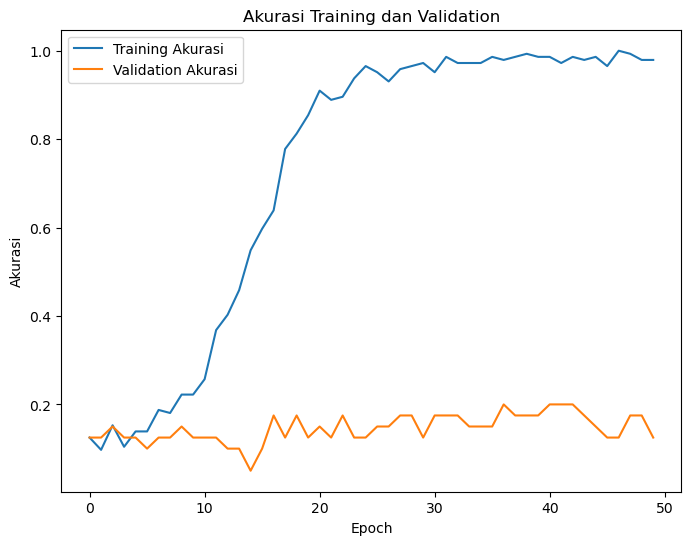

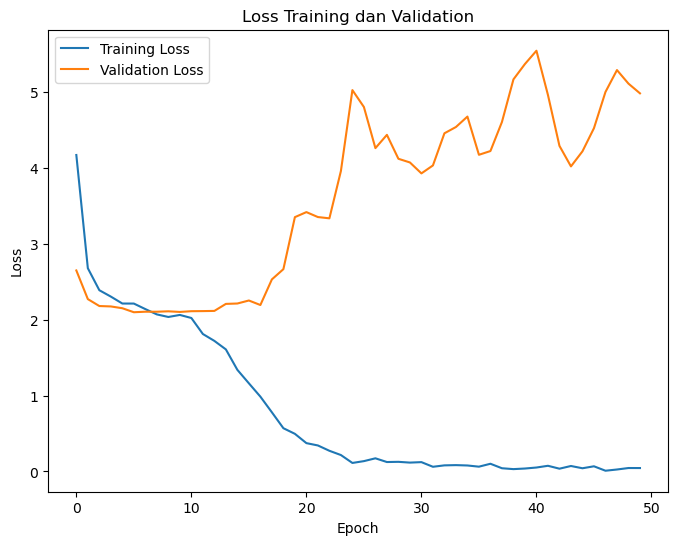

In [13]:
# 5. Visualisasi Skor Epoch

# Plot Akurasi
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Akurasi')
plt.plot(valid_accuracies, label='Validation Akurasi')
plt.title('Akurasi Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
